# Imbalance

I'm not even sure that imbalance is what I mean here. This is from the QSO project. These are the points I am trying to make.

* In section 2. Even with an estimator ($\hat{y}$) that predicts the correct mean of $y | x$, when comparing $\hat{y}$ to $y$, we find that the variance of $\hat{y}$ is less thatn $y$. The estimator underpredicts at high $y$ (these tend to be upscattered) and overpredicts at low $y$ (these tend to be downscattered). This is true given a normal distribution!
* In section 3. In the presence of scatter and cuts, it is hard to even predict the correct mean.

## Imports etc

In [13]:
%run ~/.jupyter/config.ipy

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

from hist_scatter import hist_scatter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Regression

## Data

Let's generate some data. The true function is just of the form,

$$
y = mx + \mathcal{N}(0, \sigma)
$$

Later, we will want to predict $y$ given $x$.

In [55]:
n_pts = 500000
x = np.random.normal(loc=0, scale=1, size=n_pts) * 5
x_lin = np.linspace(np.min(x), np.max(x))
no_scatter_args = [0.25]

def f_no_scatter(m, x):
    return m[0] * x

def f_noise():
    return np.random.normal(loc=0, scale=0.3, size=n_pts)

def f(x):
    return f_no_scatter(no_scatter_args, x) + f_noise()

y = f(x)

/home/christopher/.virtualenvs/learning/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/christopher/.virtualenvs/learning/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


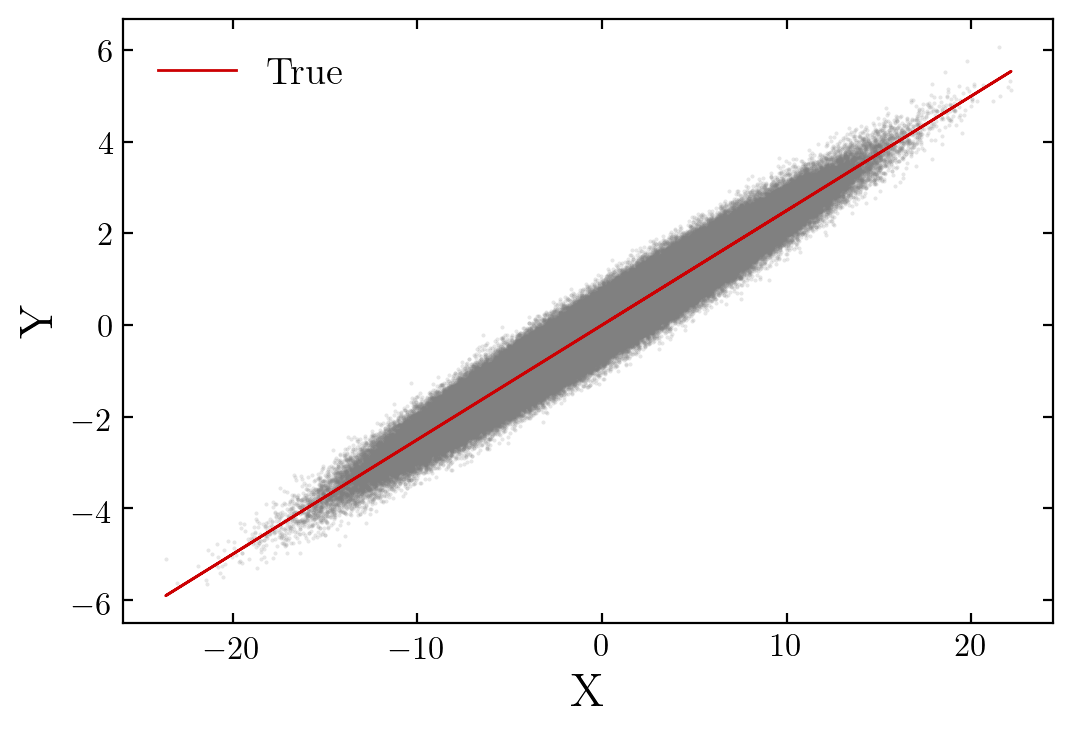

In [56]:
_, ax = plt.subplots()
ax.scatter(x, y, color="gray", alpha=0.2, s=0.2)
ax.plot(x, f_no_scatter(no_scatter_args, x), label="True")
ax.set(xlabel="X", ylabel="Y")
ax.legend()

## The obvious predictor - known params, no noise

We can build the obvious predictor - just say that,

$$
\hat{y} = mx
$$

remembering that hats imply the predicted value. We're assuming that we know $m$ here.

[[1.         0.97237382]
 [0.97237382 1.        ]]


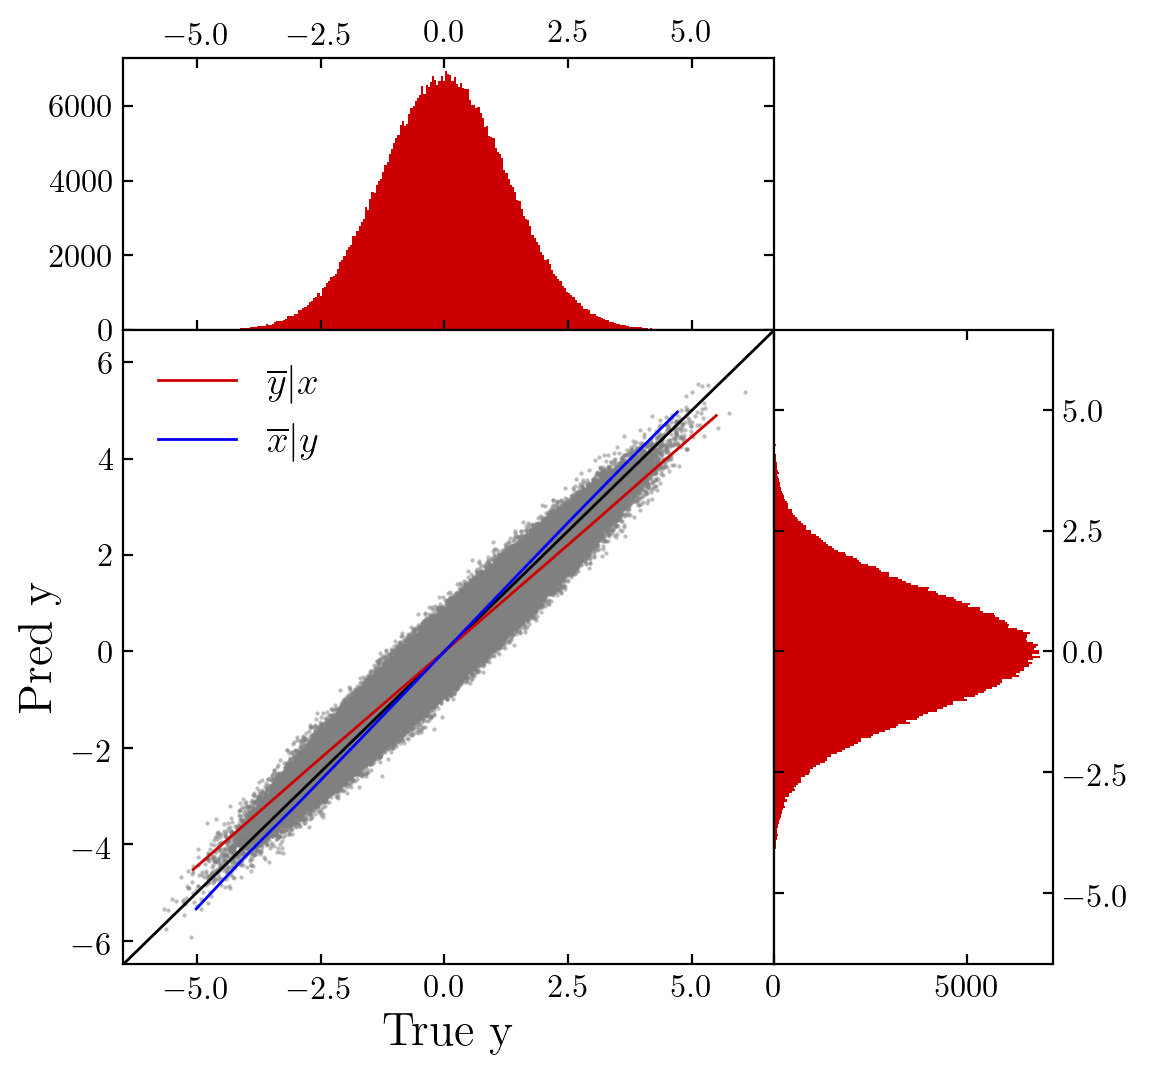

In [57]:
pred_y = f_no_scatter(no_scatter_args, x)


_, axes = hist_scatter(y, pred_y,
             scatter_kwargs=dict(color="gray", alpha=0.5, s=0.3),
             scatter_set_kwargs=dict(xlabel="True y", ylabel="Pred y"),
            )

print(np.corrcoef(y, pred_y))

This is obviously not perfect. For large (small) values of the true $y$, we are under (over) predicting. The cause of this is the noise. Our model just predicts the mean, but large values are more likely to be upscattered and small more likely to be down scattered.

What we want is a model that puts the red line on the $x = y$ line.

## The obvious predictor - unknown params, no noise

Let's now say that we don't know $m$. We can easily recover this by fitting a curve to our data. 

But again, notice that because of scatter the range of $y$ is greater than the range of the predictions. There are high $y$, upscattered values and low $y$, downscattered values. Our model will never predict these

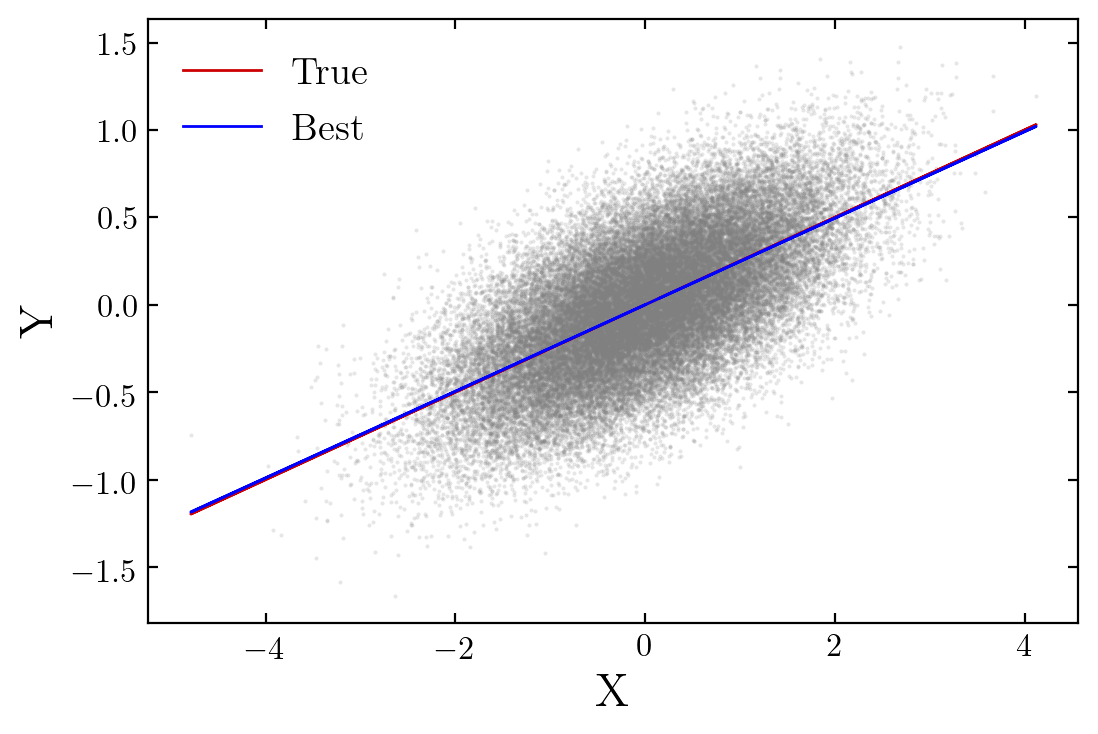

In [45]:
res = scipy.optimize.minimize(
    lambda m: np.sum(np.power(f_no_scatter(m, x) - y, 2)),
    x0 = [0],
    method = "Nelder-Mead",
)
assert res.success
best = res.x

_, ax = plt.subplots()
ax.scatter(x, y, color="gray", alpha=0.2, s=0.2)
ax.plot(x, f_no_scatter(no_scatter_args, x), label="True")
ax.plot(x, f_no_scatter(best, x), label="Best")
ax.set(xlabel="X", ylabel="Y")
ax.legend()

## The obvious predictor - known params with noise

Let's assume that we know the noise. We can then make predictions in exactly the same way as we generated the data so it should look exactly the same?

Not quite. This just adds a bias in teh other direction (previously one of our means was right the other wrong. Now both are wrong). This is because things that were previous upscattered are not necessarily the things that are upscattered here. So our model is symmetrical around the $x = y$ plane.

[[1.         0.41060736]
 [0.41060736 1.        ]]


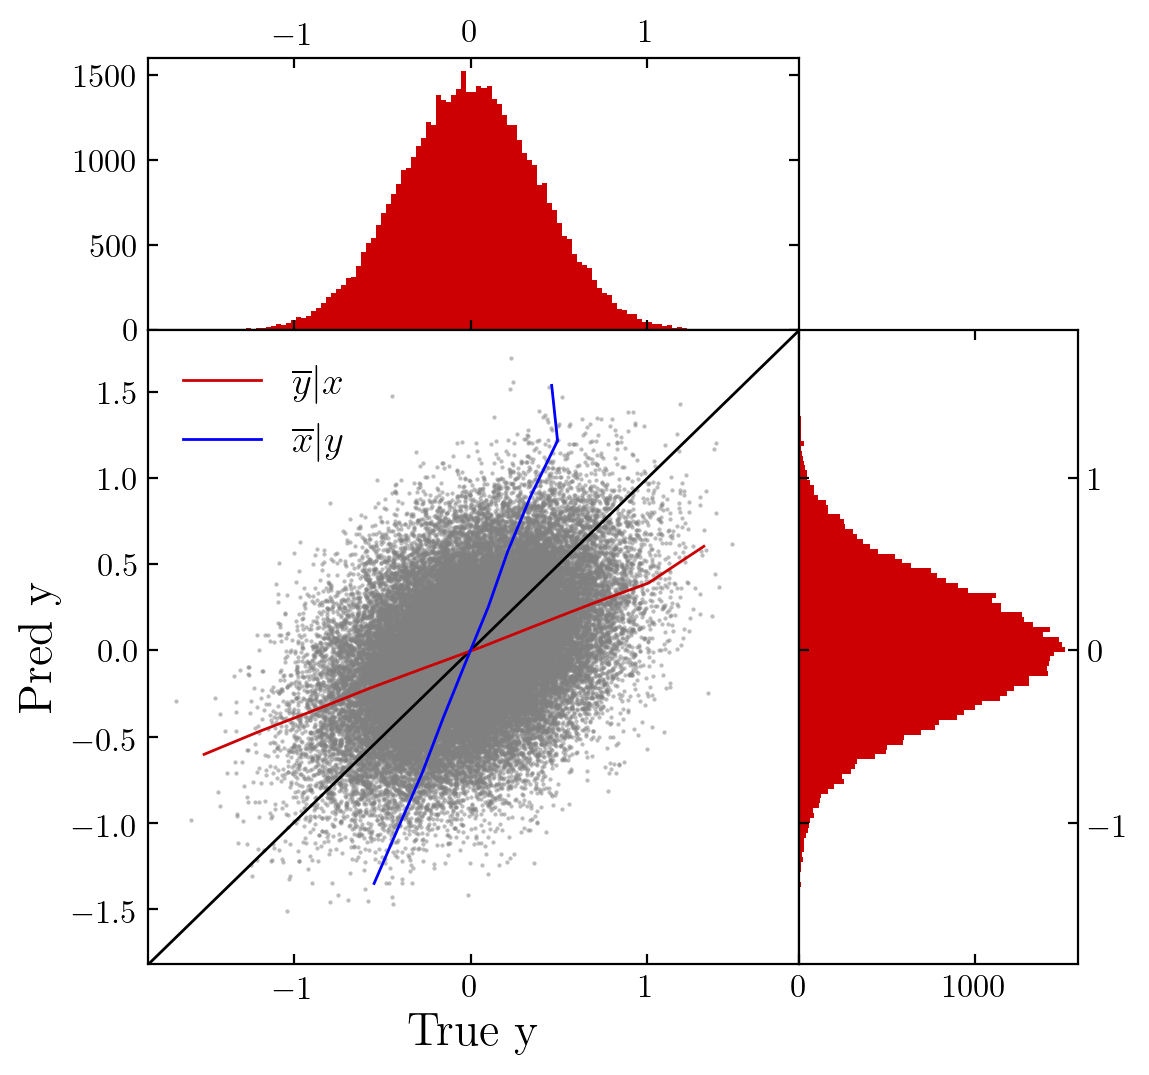

In [56]:
pred_y = f_no_scatter(no_scatter_args, x) + f_noise()

_, axes = hist_scatter(y, pred_y,
             scatter_kwargs=dict(color="gray", alpha=0.5, s=0.3),
             scatter_set_kwargs=dict(xlabel="True y", ylabel="Pred y"),
            )


print(np.corrcoef(y, pred_y))

# Regression on cut data

Let's say we have a survey with strong magnitude cuts. We also have that magnitude is dependent on some property.

In [44]:
n_pts = 50000
x_cut = np.random.rand(n_pts) * 10
x_lin_cut = np.linspace(np.min(x_cut), np.max(x_cut))

no_scatter_cut_args = [0, 0.5]

def f_no_scatter_cut(m, x):
    return m[0] + m[1] * x

def f_noise_cut():
    return np.random.normal(loc=0, scale=0.5, size=n_pts)

def f_cut(m, x):
    return f_no_scatter_cut(m, x) + f_noise_cut()

y_cut = f_cut(no_scatter_cut_args, x_cut)

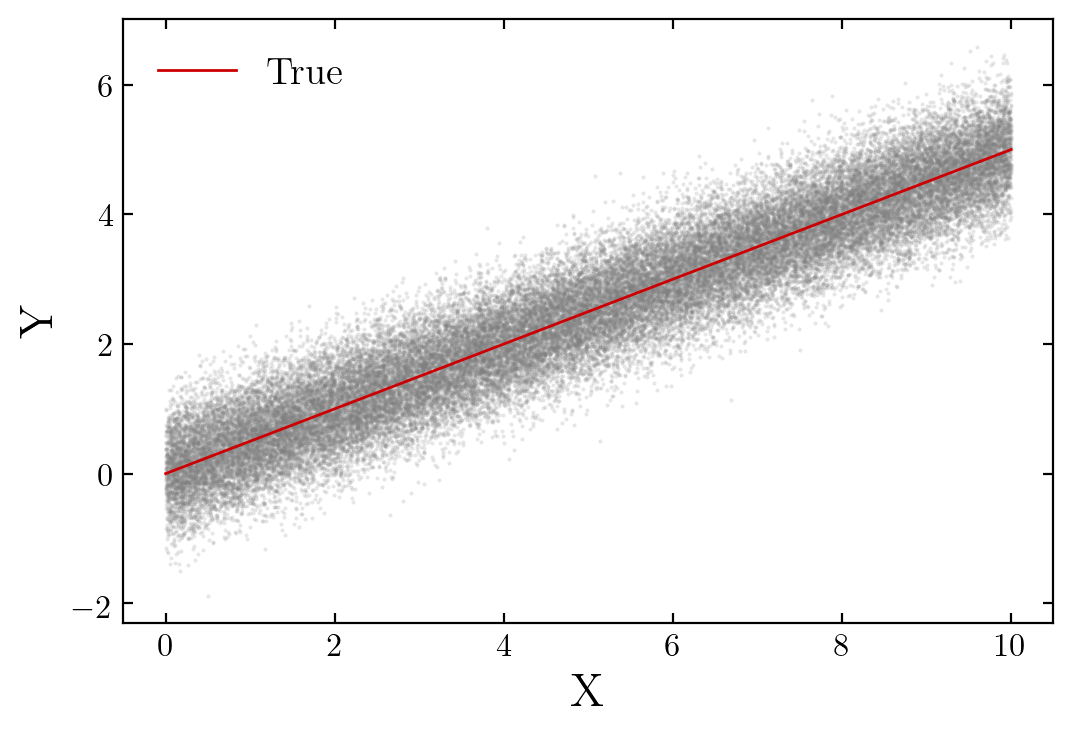

In [45]:
_, ax = plt.subplots()
ax.scatter(x_cut, y_cut, color="gray", alpha=0.2, s=0.2)
ax.plot(x_lin_cut, f_no_scatter_cut(no_scatter_cut_args, x_lin_cut), label="True")
ax.set(xlabel="X", ylabel="Y")
ax.legend()

In [46]:
cut = (y_cut > 1) & (y_cut < 4)
x_cut, y_cut = x_cut[cut], y_cut[cut]
x_lin_cut = x_lin_cut[(f_no_scatter_cut(no_scatter_cut_args, x_lin_cut) > 1) & (f_no_scatter_cut(no_scatter_cut_args, x_lin_cut) < 4)]

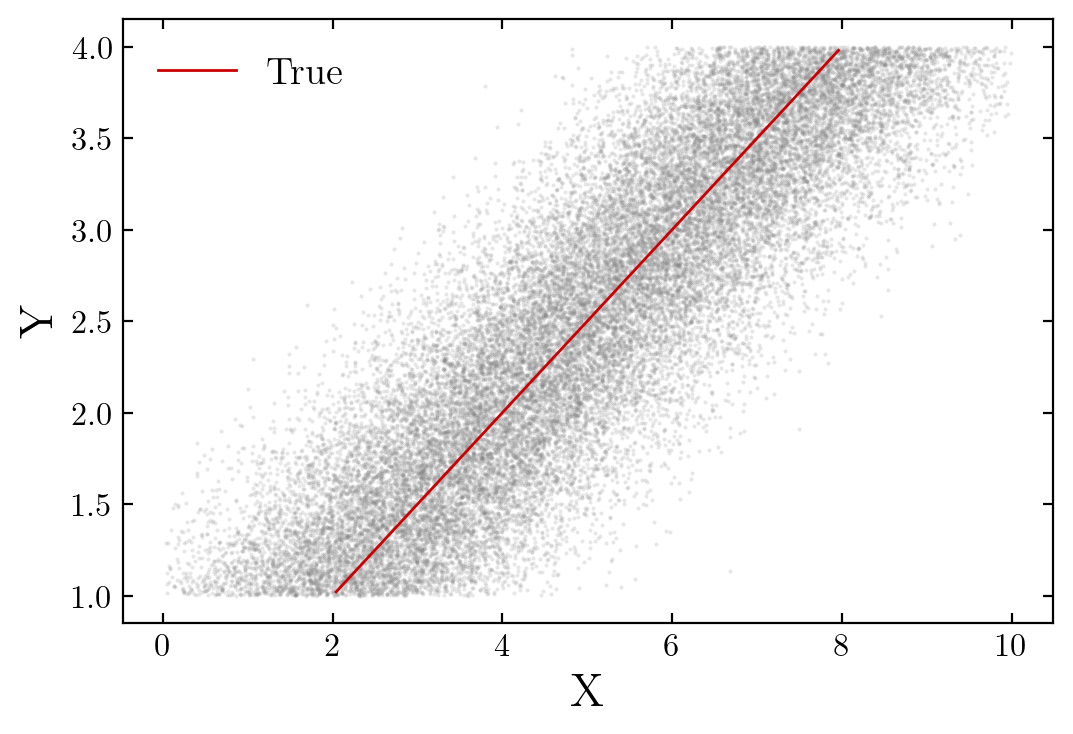

In [47]:
_, ax = plt.subplots()
ax.scatter(x_cut, y_cut, color="gray", alpha=0.2, s=0.2)
ax.plot(x_lin_cut, f_no_scatter_cut(no_scatter_cut_args, x_lin_cut), label="True")
ax.set(xlabel="X", ylabel="Y")
ax.legend()

## Unknown slope, no noise

Because of the cuts, at low values of $y$ there is a lot of upscatter. Thus we think that we need a lower value of $x$ to explain a low $y$ and so the model **overestimates** at the low $y$ end. For a similar reason, it **underestimates** at the high $y$ end.

The point is that here we also get the mean relation wrong! Note that a more flexible model will not give a line here.

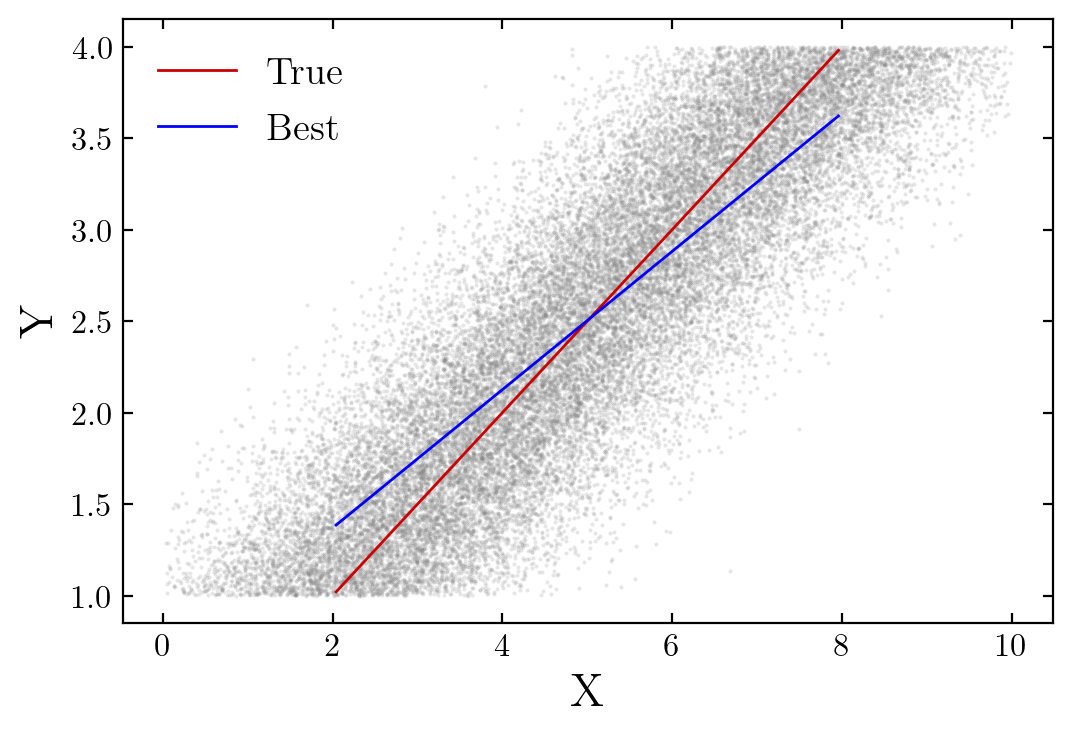

In [48]:
res = scipy.optimize.minimize(
    lambda m: np.sum(np.power(f_no_scatter_cut(m, x_cut) - y_cut, 2)),
    x0 = [0, 0, 0, 0, 0, 0],
    method = "Nelder-Mead",
)
assert res.success
best = res.x

_, ax = plt.subplots()
ax.scatter(x_cut, y_cut, color="gray", alpha=0.2, s=0.2)
ax.plot(x_lin_cut, f_no_scatter_cut(no_scatter_cut_args, x_lin_cut), label="True")
ax.plot(x_lin_cut, f_no_scatter_cut(best, x_lin_cut), label="Best")
ax.set(xlabel="X", ylabel="Y")
ax.legend()

[[1.         0.86672448]
 [0.86672448 1.        ]]


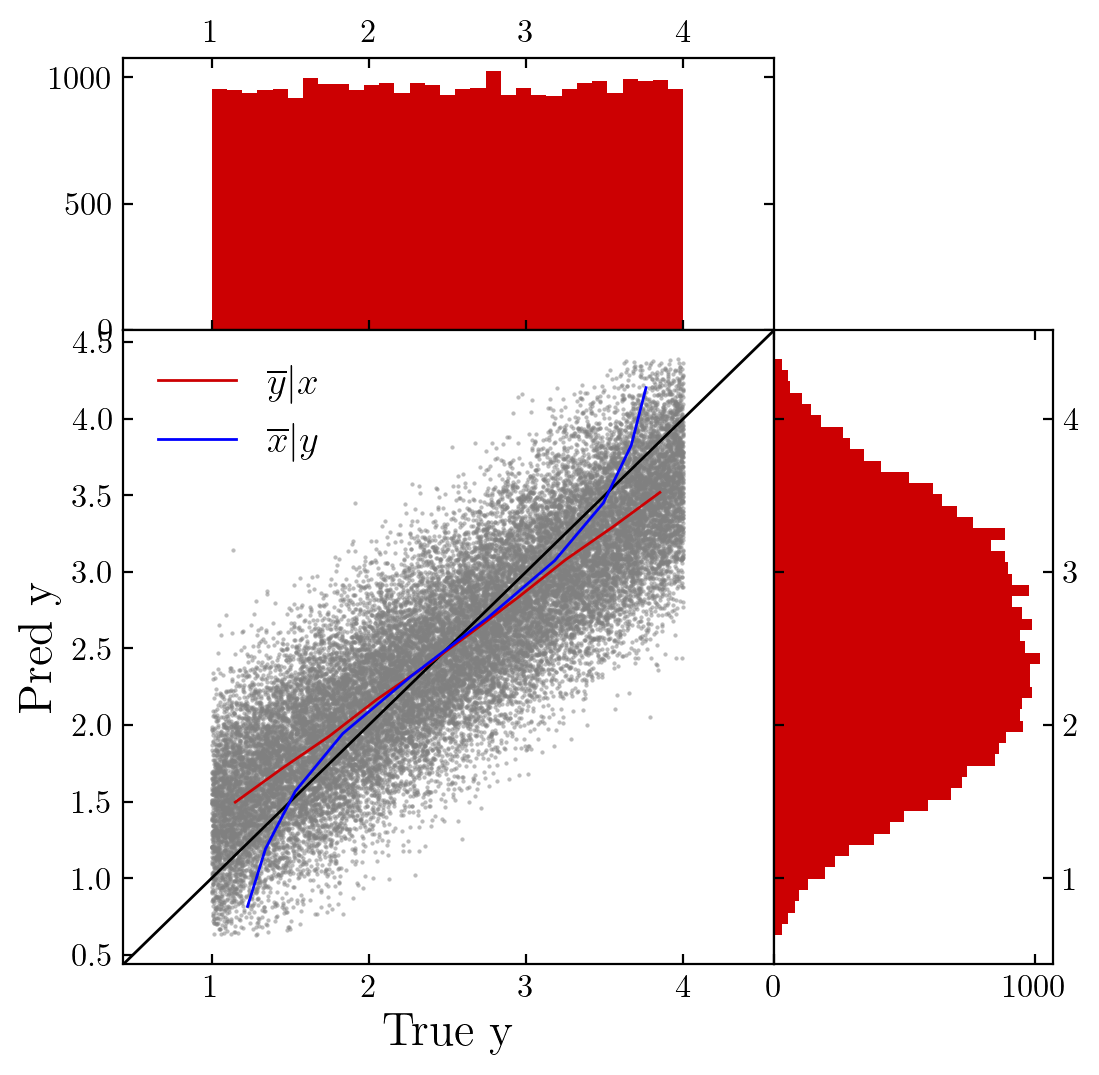

In [49]:
pred_y_cut = f_no_scatter_cut(best, x_cut)


_, axes = hist_scatter(y_cut, pred_y_cut,
             scatter_kwargs=dict(color="gray", alpha=0.5, s=0.3),
             scatter_set_kwargs=dict(xlabel="True y", ylabel="Pred y"),
            )

print(np.corrcoef(y_cut, pred_y_cut))

# The model is unbiased overall (obviously)

Obviously, because we know that the only thing other than what we have modelled is the normal error

0.003057714964651265


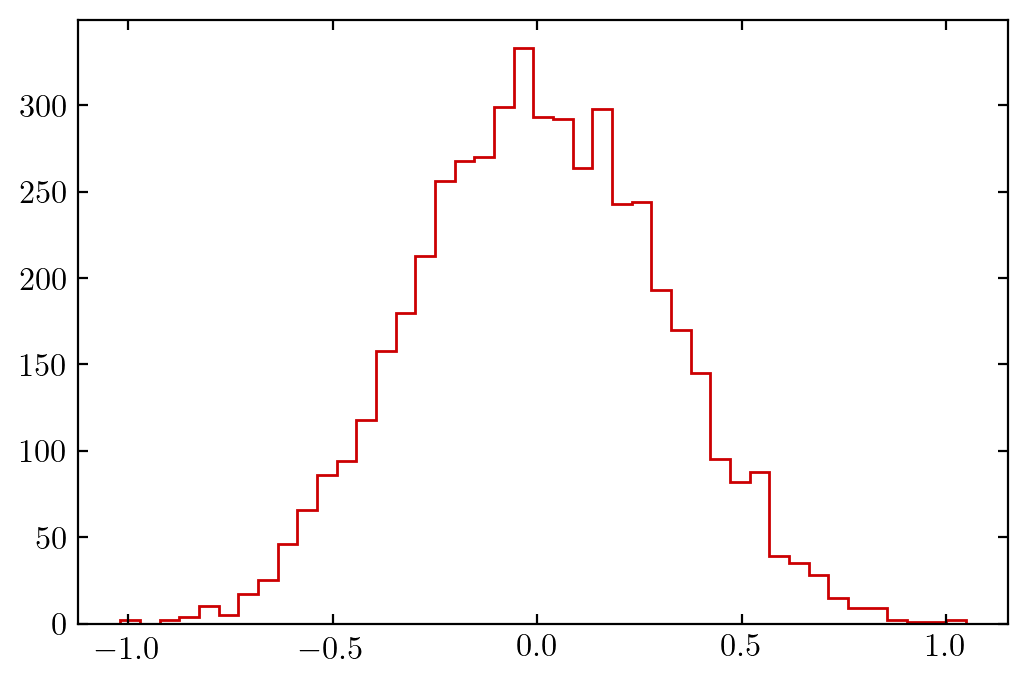

In [97]:
_, ax = plt.subplots()
pred_y = f_no_scatter(x)

ax.hist(pred_y - y, histtype="step")
print(np.mean(pred_y-y))

## But... if we take a subsample, the model is biased

-0.19673351854473883


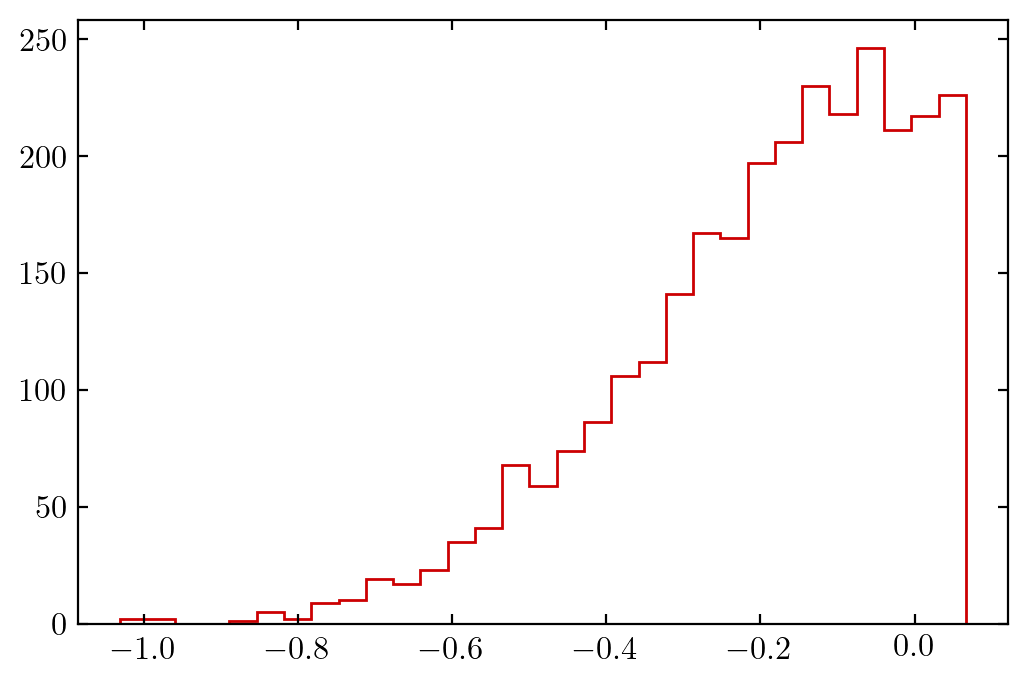

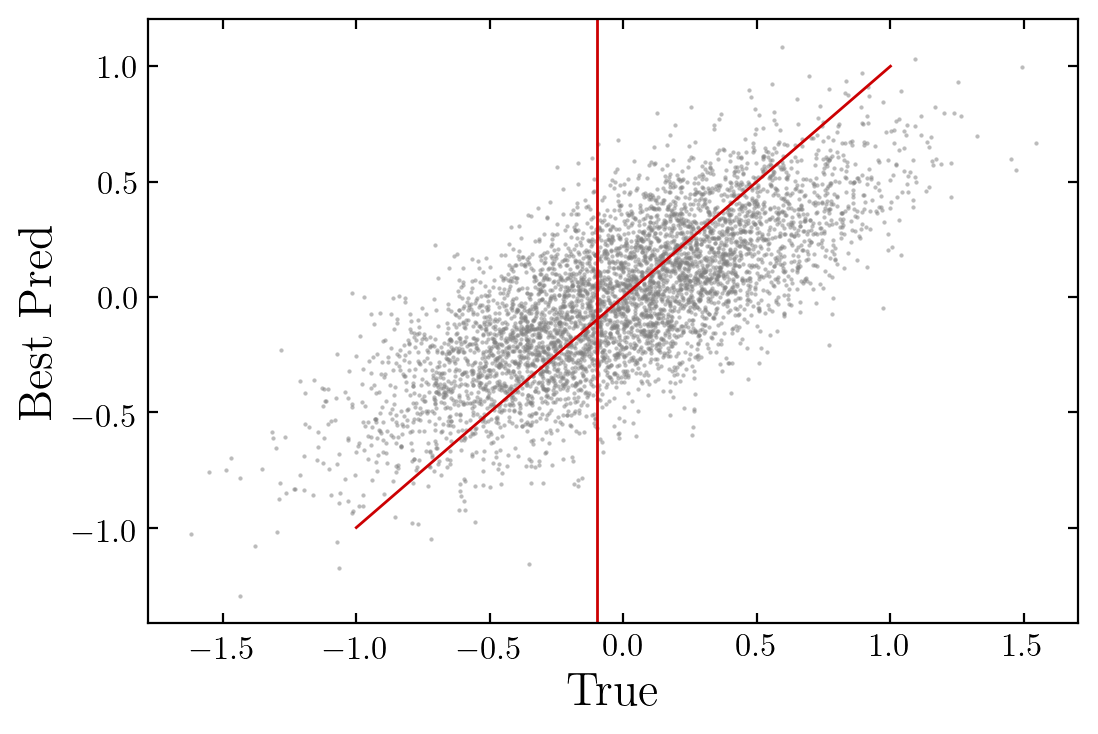

In [102]:
cut = y > -0.1
subsample_x = x[cut]
subsample_y = y[cut]
subsample_pred_y = f_no_scatter(subsample_y)

_, ax = plt.subplots()

ax.hist(subsample_pred_y - subsample_y, histtype="step")
print(np.mean(subsample_pred_y - subsample_y))


_, ax = plt.subplots()
pred_y = f_no_scatter(x)
ax.scatter(y, pred_y, color="gray", alpha=0.5, s=0.3)
l = 1
ax.plot([-l, l], [-l, l])
ax.set(xlabel="True", ylabel="Best Pred")
ax.axvline(-0.1)